In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)

        self.x = df.iloc[x_size:, 6:10].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [3]:
dataset_d = CustomDataset("DST_80.csv", 1919) #1919
dataset_f = CustomDataset("FUDS_80.csv", 2586) #2586
dataset_u = CustomDataset("US06_80.csv", 1207) #1207
print(dataset_d.x.shape)
print(dataset_d.y.shape)
print(dataset_f.x.shape)
print(dataset_f.y.shape)
print(dataset_u.x.shape)
print(dataset_u.y.shape)
print(dataset_d)
print(len(dataset_d))
print(len(dataset_f))
print(len(dataset_u))

(10639, 4)
(10639, 1)
(11095, 4)
(11095, 1)
(10690, 4)
(10690, 1)
10639
11095
10690


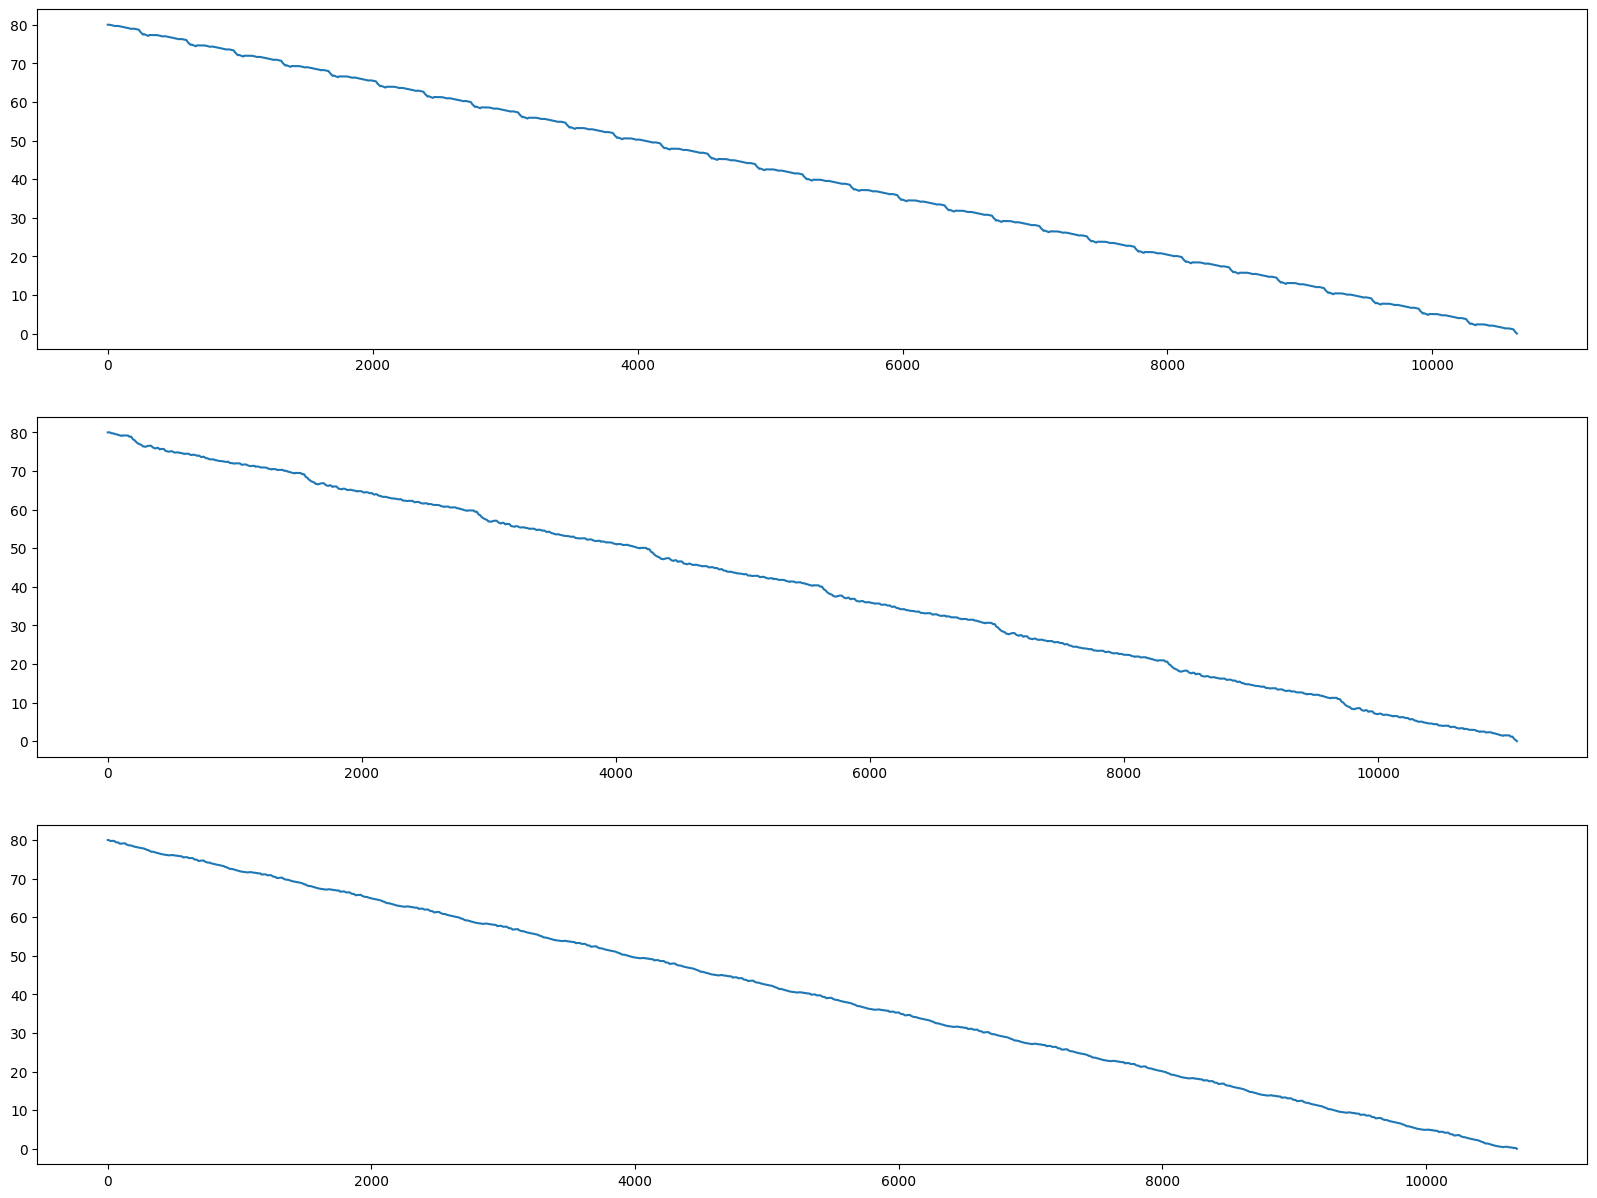

In [4]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.plot(dataset_d.y)
plt.subplot(3,1,2)
plt.plot(dataset_f.y)
plt.subplot(3,1,3)
plt.plot(dataset_u.y)
plt.show()

In [5]:
dataset = torch.utils.data.ConcatDataset([dataset_u, dataset_f, dataset_d]) #x,y 어떻게된지 모름

train_dataset, test_dataset = random_split(dataset, [len(dataset_u)+len(dataset_f), len(dataset_d)])

In [6]:
print(len(train_dataset))
print(len(test_dataset))

print(len(dataset_d))
print(len(dataset_f))
print(len(dataset_u))
print(len(dataset_d)+len(dataset_f))

21785
10639
10639
11095
10690
21734


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, drop_last=False)
#validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=False)

In [8]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.batchnormal = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [9]:
num_epochs = 1000
learning_rate = 0.001

input_size = 4
hidden_size = 64
num_layers = 1

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, 4)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# def train_loop(model, dataloader, loss_func, optimizer):
#     model.train()
#     size = len(dataloader.dataset)
#     print("Training")
#     running_loss = 0.
#     last_loss = 0.

#     for batch, (x,y) in tqdm(enumerate(dataloader)):
#         pred = model(x)
#         loss = loss_func(pred, y)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 100 == 0:
#             loss, current = loss.item(), (batch + 1) * len(x)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [11]:
# def test_loop(model, dataloader, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     test_loss, correct = 0, 0

#     with torch.no_grad():
#         for x, y in dataloader:
#             pred = model(x)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()

#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
model.train()

with tqdm(range(num_epochs)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y, in train_dataloader:
            optimizer.zero_grad()
            x = x.float()
            y = y.float()
            output = model(x)
            loss = loss_func(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_dataloader)))

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_7672\1241854177.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  feature = torch.FloatTensor([self.x[index]])
100%|██████████| 1000/1000 [28:33<00:00,  1.71s/it, loss=0.00332]


In [13]:
# arr = np.concatenate([dataset_d.x, dataset_f.x], axis = 0)
# arr.shape


In [14]:
X = torch.Tensor(dataset_d.x)
X1 = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

Y = torch.Tensor(dataset_d.y)

train_predict = model(X1)
predicted = train_predict.data.numpy()
#(20000, 1, 1)

predicted = predicted.squeeze()
predicted.shape


(10639,)

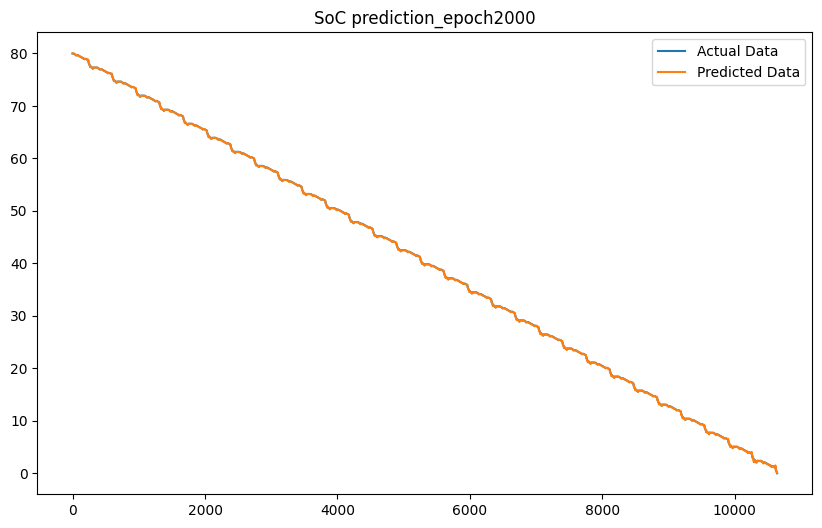

In [15]:
label_y = Y.data.numpy()

plt.figure(figsize=(10,6))
plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('SoC prediction_epoch2000')
# plt.xlim(0,1000)
# plt.ylim(73,80)
plt.legend()
plt.show()

In [16]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

act = label_y.squeeze()
mape(act, predicted)

C:\Users\user\AppData\Local\Temp\ipykernel_7672\973135883.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((actual - pred) / actual)) * 100


inf

In [17]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(act, predicted)

0.02991169

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(act, predicted)
np.sqrt(MSE)

0.037666447